   file    bx    by    bz    bl    bm    bn  bmag      vx      vy     vz  \
0    55  0.52  3.99 -2.53  0.12 -4.74 -0.33  4.75 -212.49  126.52  94.29   
1    55 -0.46  2.83 -0.37  1.47 -2.49 -0.08  2.89 -205.30  121.80  91.70   
2    55  0.63  3.69 -2.23  0.10 -4.36 -0.12  4.36 -208.85  119.43  89.61   

     vmag    np    tpar    tper  goal  
0  264.67  5.51  141.67  157.74     2  
1  255.72  6.51  139.22  154.13     2  
2  256.73  6.15  144.39  151.92     2  


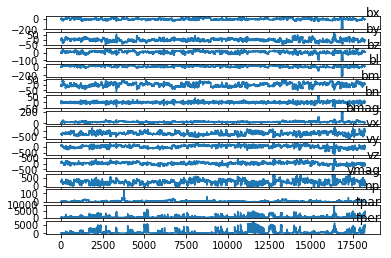

In [1]:
import numpy as np
import tensorflow as tf

from pandas import read_excel

from matplotlib import pyplot

#does it make any difference?
%matplotlib inline

#Loading the raw dataset
dataset = read_excel("challenge_dataset.xlsx", usecols="B:Q")

values = dataset.values

# Lets print the first 3 rows of the dataset
print(dataset.head(3))

#Lets create a quick plot of each series (as a separate subplot) and see what we have
i = 0
Nc = 14 #plotting columns 1 to 14
pyplot.figure()
for group in range(1,Nc+1):
    i += 1
    pyplot.subplot(Nc, 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
pyplot.show()


In [2]:
# ensuring all the data is float
values = values.astype('float32')

# normalizing features (columns 1 to 14) NOTE: column 15 = goal (three classes: 0, 1, 2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,0:15])
#scaled = values[:,0:15]

import pandas as pd
df = pd.DataFrame(scaled)

print("values.shape =", values.shape)
print("df.shape     =", df.shape)
#print('df:', df.head())
#print('dataset:', dataset.head())


values.shape = (18245, 16)
df.shape     = (18245, 15)


In [3]:
# split the data into train and test sets
# taking 80% of the data for training
n_train = 89 * int( values.shape[0]/89 * 0.80) #each time series has 89 entities

# inputs
train_X = np.array(scaled[:n_train, :])
test_X  = np.array(scaled[n_train:, :])
# outpts (making sure outputs are arrays of integers)
last_column = values.shape[1] - 1 #last column (goal) in he raw dataset
train_y = np.array(values[:n_train, last_column], dtype=int)
test_y  = np.array(values[n_train:, last_column], dtype=int)

# Lets convert Y from its current shape (m,1) into a "one-hot representation" (m,3),
# to make it suitable for a softmax classifier.
# Now each row in Y_oh will be a one-hot vector giving the class (0, 1, or 2)
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
train_Y_oh = convert_to_one_hot(train_y, C = 3)
test_Y_oh  = convert_to_one_hot(test_y,  C = 3)

# reshape input data to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape( (test_X.shape[0],  1, test_X.shape[1]))
print("train_X.shape =", train_X.shape)
print("test_X.shape  =", test_X.shape)

print("train_y.shape =", train_y.shape)
print("test_y.shape  =", test_y.shape)
print("train_y.shape =", train_Y_oh.shape)
print("train_y.shape =", test_Y_oh.shape)


train_X.shape = (14596, 1, 15)
test_X.shape  = (3649, 1, 15)
train_y.shape = (14596,)
test_y.shape  = (3649,)
train_y.shape = (14596, 3)
train_y.shape = (3649, 3)


Train on 14596 samples, validate on 3649 samples
Epoch 1/20
 - 2s - loss: 1.1039 - acc: 0.3248 - val_loss: 1.1985 - val_acc: 0.1951
Epoch 2/20
 - 0s - loss: 1.0737 - acc: 0.4205 - val_loss: 1.2085 - val_acc: 0.1946
Epoch 3/20
 - 0s - loss: 1.0600 - acc: 0.4411 - val_loss: 1.2062 - val_acc: 0.2527
Epoch 4/20
 - 0s - loss: 1.0430 - acc: 0.4818 - val_loss: 1.2048 - val_acc: 0.2518
Epoch 5/20
 - 0s - loss: 1.0286 - acc: 0.5243 - val_loss: 1.2071 - val_acc: 0.2527
Epoch 6/20
 - 0s - loss: 1.0189 - acc: 0.5395 - val_loss: 1.2100 - val_acc: 0.2518
Epoch 7/20
 - 0s - loss: 1.0123 - acc: 0.5437 - val_loss: 1.2122 - val_acc: 0.2527
Epoch 8/20
 - 0s - loss: 1.0075 - acc: 0.5464 - val_loss: 1.2136 - val_acc: 0.2535
Epoch 9/20
 - 0s - loss: 1.0039 - acc: 0.5480 - val_loss: 1.2144 - val_acc: 0.2532
Epoch 10/20
 - 0s - loss: 1.0011 - acc: 0.5493 - val_loss: 1.2146 - val_acc: 0.2538
Epoch 11/20
 - 0s - loss: 0.9987 - acc: 0.5505 - val_loss: 1.2144 - val_acc: 0.2535
Epoch 12/20
 - 0s - loss: 0.9967 - a

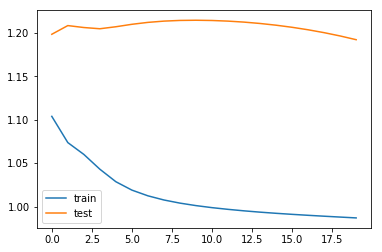

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                20480     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_13 (Activation)   (None, 3)                 0         
Total params: 20,675
Trainable params: 20,675
Non-trainable params: 0
_________________________________________________________________


In [16]:
#import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras import optimizers

# designing the network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3, activation='softmax'))
model.add(Activation('softmax'))

np.random.seed(3)

opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

### optimizer='adam'
### loss='categorical_accuracy', 'msle'
### metrics=['accuracy'], ['msle', 'mae']
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# fit network
history = model.fit(train_X, train_Y_oh, epochs=20, batch_size=89,
                    validation_data=(test_X, test_Y_oh), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#summarize the model
model.summary()